# Demo of pytikz, a Python interface to Ti*k*Z

The import package is called `tikz`. For interactive use, importing the contents into the current namespace is more convenient.

In [1]:
# %#load_ext autoreload
# %#autoreload 2

# using https://github.com:soraxas/pytikz

from itertools import chain
import matplotlib.pyplot as plt

import tikz
from tikz import *


def opts(*iterable, **kwargs):
    return ",".join(chain(iterable, (f"{k}={v}" for k, v in kwargs.items())))


def coor_remove_bkt(text):
    text = tikz._coordinate(text)
    if isinstance(text, np.ndarray):
        text = tuple(text)
    text = str(text).strip()
    if text[0] == "(" and text[-1] == ")":
        text = text[1:-1]
    return text


def from_some_distance_away(pt_origin, pt_ref, distance="5mm", angle=-90):
    return f"(${pt_origin}!{distance}!{angle}:{pt_ref}$)"


def prepare_pic():
    pic = Picture()
    pic.usetikzlibrary("calc,shapes.geometric")

    # circle
    pic.usetikzlibrary("angles,quotes")

    # pic = Picture(scale=3, line_cap="round")
    pic.usepackage(r"tikz-dimline")

    pic.tikzset(
        r"""dot/.style={circle,fill=blue,minimum size=3pt, inner sep=0pt},
             square/.style={rectangle,fill=red,minimum size=4pt, inner sep=0pt,%    
                        rotate=30,anchor=center},%
            mytext/.style={anchor=north,text width=3cm,align=center}"""
    )
    return pic


def dimline(content, pt1, pt2, extension_length="5mm", opt=None, flip: bool = False):
    if opt is None:
        opt = []
    opt.append(f"extension start length={extension_length}")
    opt.append(f"extension end length={extension_length}")

    flip_sign = -1 if flip else 1

    dimline_pt1 = from_some_distance_away(pt1, pt2, angle=flip_sign * 90)
    dimline_pt2 = from_some_distance_away(pt2, pt1, angle=flip_sign * (-90))

    def wrap_b(text):
        return "{" + str(text) + "}"

    return rf"\dimline[{','.join(opt)}] {wrap_b(dimline_pt1)}{wrap_b(dimline_pt2)}{wrap_b(content)}"


def define_right_angle_drawing(pic):
    # right angle drawing
    pic.tikzset(
        r"""
        right angle quadrant/.code={
            \pgfmathsetmacro\quadranta{{1,1,-1,-1}[#1-1]}     % Arrays for selecting quadrant
            \pgfmathsetmacro\quadrantb{{1,-1,-1,1}[#1-1]}},
        right angle quadrant=1, % Make sure it is set, even if not called explicitly
        right angle length/.code={\def\rightanglelength{#1}},   % Length of symbol
        right angle length=2ex, % Make sure it is set...
        right angle symbol/.style n args={3}{
            insert path={
                let \p0 = ($(#1)!(#3)!(#2)$),     % Intersection
                    \p1 = ($(\p0)!\quadranta*\rightanglelength!(#3)$), % Point on base line
                    \p2 = ($(\p0)!\quadrantb*\rightanglelength!(#2)$), % Point on perpendicular line
                    \p3 = ($(\p1)+(\p2)-(\p0)$) in  % Corner point of symbol
                (\p1) -- (\p3) -- (\p2)
            }
        }
        """
    )


def draw_right_angle(pic, line_pt1, line_pt2, pt3, raq=2):
    """
        \ (line_pt1)
         \
          \
     .     \ (line_pt2)
    (pt3)
    """
    return pic.draw(
        rf"(${line_pt1}!{line_pt2}!{pt3}$)",
        opt=opts(
            rf"right angle quadrant={raq}",
            rf"right angle length=2mm",
            rf"right angle symbol="
            rf"{{{coor_remove_bkt(line_pt1)}}}"
            rf"{{{coor_remove_bkt(line_pt2)}}}"
            rf"{{{coor_remove_bkt(pt3)}}}",
        ),
    )


def pt_of_intersect(line_pt1, line_pt2, pt3):
    return rf"($({coor_remove_bkt(line_pt1)})!({coor_remove_bkt(line_pt2)})!({coor_remove_bkt(pt3)})$)"


pt_of_intersect((0, 1), (1, 2), np.array([1, 2]))

'($(0, 1)!(1, 2)!(1, 2)$)'


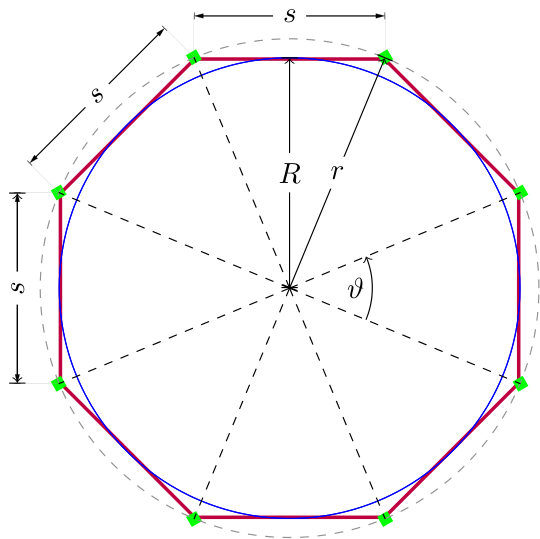

\documentclass{article}
\usepackage{tikz}
\usetikzlibrary{external}
\tikzexternalize
\usetikzlibrary{calc,shapes.geometric}
\usetikzlibrary{angles,quotes}
\usepackage{tikz-dimline}
\begin{document}

\begin{tikzpicture}
\tikzset{dot/.style={circle,fill=blue,minimum size=3pt, inner sep=0pt},
             square/.style={rectangle,fill=red,minimum size=4pt, inner sep=0pt,%    
                        rotate=30,anchor=center},%
            mytext/.style={anchor=north,text width=3cm,align=center}}
\node[inner sep=0,very thick,regular polygon,draw=purple,regular polygon sides=8,minimum size = 6cm] (P) {};
\node[square,green] at (P.corner 1) {};
\node[square,green] at (P.corner 2) {};
\node[square,green] at (P.corner 3) {};
\node[square,green] at (P.corner 4) {};
\node[square,green] at (P.corner 5) {};
\node[square,green] at (P.corner 6) {};
\node[square,green] at (P.corner 7) {};
\node[square,green] at (P.corner 8) {};
\path let \p1=($(P.center)-(P.side 1)$) in node[circle,inner sep=0,minimum

In [2]:
pic = prepare_pic()


nside = 8
diameter = 6

# polygon
pic.node(
    "",
    opt=opts(
        "inner sep=0",
        "very thick",
        "regular polygon",
        "draw=purple",
        f"regular polygon sides={nside}",
        f"minimum size = {diameter}cm",
        #         "rotate=-70",
    ),
    name="P",
)
# ploygon node
for i in range(1, nside + 1):
    pic.node("", opt=opts("square", "green"), at=f"(P.corner {i})")

# inner circle
pic.path(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    node(
        "",
        opt=opts(
            "circle",
            "inner sep=0",
            r"minimum width={2*veclen(\x1,\y1)-\pgflinewidth}",
            "draw=blue",
        ),
        at="(P)",
    ),
)
# outer circle
# \path let \p1=($(b.center)-(b.side 1)$) in node[circle, inner sep=0, minimum width=, draw=gray, dashed] at (b) {};
pic.path(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    node(
        "",
        opt=opts(
            "circle",
            "inner sep=0",
            r"minimum width={2*veclen(\x1,\y1)-\pgflinewidth}",
            "draw=blue",
        ),
        at="(P)",
    ),
)
pic.path(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    node(
        "",
        opt=opts(
            "circle",
            "inner sep=0",
            r"minimum width={"
            rf"2*(sqrt(2)*veclen(\x1,\y1))/( sqrt(cos(360/{nside}) + 1 ) )-\pgflinewidth"
            r"}",
            "draw=gray",
            "dashed",
        ),
        at="(P)",
    ),
)
# dimensions
pic.draw(
    "(P.center)",
    "--",
    "(P.side 1)",
    node("$R$", opt=opts("midway", "fill=white")),
    opt="|->|",
)
pic.draw(
    "(P.center)",
    "--",
    "(P.corner 1)",
    node("$r$", opt=opts("midway", "fill=white")),
    opt="|->|",
)
pic.draw(
    from_some_distance_away("(P.corner 3)", "(P.corner 4)"),
    "--",
    node("$a$", opt="fill=white"),
    from_some_distance_away("(P.corner 4)", "(P.corner 3)", angle="90"),
    opt="|<->|",
)

for i in range(4, 1, -1):
    pic.raw(dimline("$s$", f"(P.corner {i})", f"(P.corner {i-1})"))

for i in range(2, nside + 1):
    pic.draw(
        "(P.center)",
        "--",
        f"(P.corner {i})",
        #         node("$r$", opt=opts("midway", "fill=white")),
        opt="dashed",
    )

# theta

scope = pic.scope()
scope.coordinate("O", "(P.center)")
scope.coordinate("p1", "(P.corner 7)")
scope.coordinate("p2", "(P.corner 8)")
scope.draw(
    r'pic [draw,->,angle radius=1cm,angle eccentricity=.8,"$\vartheta$"] {angle = p1--O--p2}'
)

# print(pic.document_code())
pic.demo(dpi=210)
print(pic.document_code())


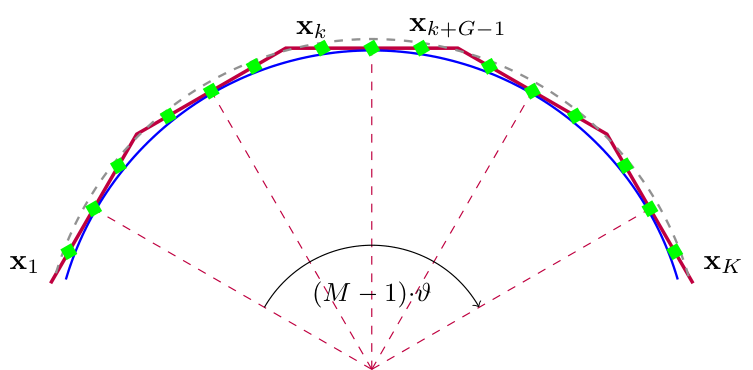

In [3]:
pic = prepare_pic()


nside = 12
CORNERS = (11, 12, 1, 2, 3, 4)
diameter = 8

scope = pic.scope()
scope.clip(
    (-diameter / 2, 0),
    "rectangle",
    (2, 0),
)
# polygon
scope.node(
    "",
    opt=opts(
        "draw=none",
        "inner sep=0",
        "very thick",
        "regular polygon",
        #         "draw=purple",
        f"regular polygon sides={nside}",
        f"minimum size = {diameter}cm",
        #         "rotate=-70",
    ),
    name="P",
)

# # ploygon node
# for i in CORNERS:
#     pic.node("", opt=opts("square", "green"), at=f"(P.corner {i})")

pic.draw(
    "",
    "--".join(f"(P.corner {i})" for i in CORNERS),
    opt="thick,purple, very thick",
)

# inner circle
import numpy as np

_angle_per_side = (360 / (nside - 1)) * 1
_start_angle = CORNERS
_start_angle = _angle_per_side * 0.5
_end_angle = _angle_per_side * 5
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*cos({_start_angle})"
    + r"},{"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(veclen(\x1,\y1)-\pgflinewidth)}})",
    opt=opts("blue", "thick"),
)


# outer circle
# \path let \p1=($(b.center)-(b.side 1)$) in node[circle, inner sep=0, minimum width=, draw=gray, dashed] at (b) {};
_start_pt_str = (
    rf"sqrt(2)*veclen(\x1,\y1))/( sqrt(cos(360/{nside}) + 1 ) )-\pgflinewidth"
)
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"({_start_pt_str})*cos({_start_angle})"
    + r"},{"
    + rf"({_start_pt_str})*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(({_start_pt_str})}})",
    opt=opts(
        "blue",
        "thick",
        "draw=gray",
        "dashed",
    ),
)

# dimensions


# for i in range(4, 1, -1):
#     pic.raw(dimline("$s$", f"(P.corner {i})", f"(P.corner {i-1})"))

for i in [11, 12, 1, 2, 3]:
    pic.draw(
        "(P.center)",
        "--",
        #         f"(P.side {i})",
        from_some_distance_away("(P.center)", f"(P.side {i})", angle=0, distance="4cm"),
        #         node("$r$", opt=opts("midway", "fill=white")),
        opt=opts("purple", "dashed"),
    )

# theta

pic.coordinate("O", "(P.center)")
pic.coordinate("p1", "(P.side 3)")
pic.coordinate("p2", "(P.side 1)")
# pic.draw(
#     r'pic [draw,<-,angle radius=.8cm,angle eccentricity=.6,"\tiny $m\vartheta$", fill=white] {angle = p2--O--p1}'
# )
pic.coordinate("p2", "(P.side 11)")
pic.draw(
    r'pic [draw,<-,angle radius=1.5cm,angle eccentricity=.6,"\small ${(M-1)\cdot}\vartheta$"] {angle = p2--O--p1}'
)


for i, _side in enumerate([3, 2, 1, 12, 11]):
    _label = i + 1
    if _label == 2:
        _label = r"{\ldots}"
    elif _label == 3:
        _label = "k"
    elif _label == 4:
        _label = "{k+1}"
    elif _label == 5:
        _label = "{K-1}"
    pic.coordinate(
        "",
        opt=opts(
            "square",
            "green",
            "minimum size=1.5mm",
            #             f"label=$x_{_label}$",
            "label distance=4mm",
        ),
        at=f"(P.side {_side})",
    )
    for symbol in ["+", "-"]:
        pic.coordinate(
            "",
            opt=opts(
                "square",
                "green",
                "minimum size=1.5mm",
                "label distance=4mm",
            ),
            at=from_some_distance_away(
                f"(P.side {_side})",
                f"(P.corner {_side})",
                angle=0,
                distance=f"{symbol}6mm",
            ),
        )

pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=above right:$\mathbf{x}_{K}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 11)",
)
pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=above left:$\mathbf{x}_{1}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 4)",
)
pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=above right:$\mathbf{x}_{k}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 2)",
)
pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=above:$\mathbf{x}_{k + G - 1}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 1)",
)

# \clip (-15,-15) rectangle (15,15);  % <----


# print(pic.code())
pic.demo(dpi=210)
# print(pic.document_code())

In [4]:
def get_coor(m, M, R):
    # infer side length
    s = np.tan(2 * np.pi / nside / 2) * R * 2
    ##################
    thetaw = 2 * np.arctan2(s, 2 * R)

    _t = (2 * m - M - 1) * np.arctan2(s, 2 * R)
    #     _t = np.pi/2
    print(_t)
    return R * np.array([np.sin(_t), np.cos(_t)])


def get_coor2(k, M, R, G, d_inter_spacing=0.5):
    # infer side length
    s = np.tan(2 * np.pi / nside / 2) * R * 2
    ##################
    thetaw = 2 * np.arctan2(s, 2 * R)
    #
    #     m =

    _t = (2 * ((k - 1) // G) - M + 1) * np.arctan2(s, 2 * R)

    return (
        np.array(
            [
                [np.cos(_t), np.sin(_t)],  #
                [-np.sin(_t), np.cos(_t)],  #
            ]
        )
        @ np.diag(
            [d_inter_spacing * ((((k - 1) % G) + 1) - (G + 1) / 2), R],
        )
        @ np.ones(2)
    )


# get_coor(3, 5, 4)
get_coor2(8, 5, 4, 3)

get_coor2(8, 6, 4, 3)

array([-1.03527618,  3.86370331])

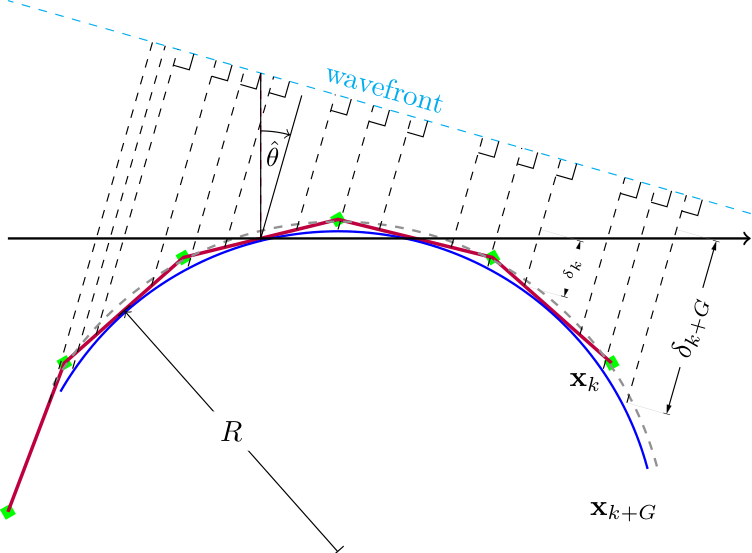

In [5]:
pic = prepare_pic()

define_right_angle_drawing(pic)


## define styles
pic.style("important line", very_thick=True)

# define colors
pic.colorlet("anglecolor", "green!50!black")
pic.colorlet("sincolor", "red")
pic.colorlet("coscolor", "blue")
pic.colorlet("tancolor", "orange!80!black")

# background grid
# pic.draw((-1.4, -1.4), grid((1.4, 1.4), step="0.5cm"), help_lines=True, very_thin=True)

# circle
# pic.draw((0, 0), circle(radius=1))
# pic.draw((0, 0), node("$a$", radius=1))

nside = 13
CORNERS = (nside - 1, nside, 1, 2, 3, 4)
diameter = 8

# polygon
scope = pic.scope()
scope.clip(
    (-diameter / 2, 0),
    "rectangle",
    (2, 0),
)
scope.node(
    "",
    opt=opts(
        "inner sep=0",
        "very thick",
        "regular polygon",
        #         "draw=purple",
        f"regular polygon sides={nside}",
        f"minimum size = {diameter}cm",
        #         "rotate=-70",
    ),
    name="P",
)

# ploygon node
for i in CORNERS:
    pic.node("", opt=opts("square", "green"), at=f"(P.corner {i})")

pic.draw(
    "",
    "--".join(f"(P.corner {i})" for i in CORNERS),
    opt="thick,purple, very thick",
)

# inner circle
import numpy as np

_angle_per_side = (360 / (nside - 1)) * 1
_start_angle = CORNERS
_start_angle = _angle_per_side * 0.5
_end_angle = _angle_per_side * 5
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*cos({_start_angle})"
    + r"},{"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(veclen(\x1,\y1)-\pgflinewidth)}})",
    opt=opts("blue", "thick"),
)


# outer circle
# \path let \p1=($(b.center)-(b.side 1)$) in node[circle, inner sep=0, minimum width=, draw=gray, dashed] at (b) {};
_start_pt_str = (
    rf"sqrt(2)*veclen(\x1,\y1))/( sqrt(cos(360/{nside}) + 1 ) )-\pgflinewidth"
)
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"({_start_pt_str})*cos({_start_angle})"
    + r"},{"
    + rf"({_start_pt_str})*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(({_start_pt_str})}})",
    opt=opts(
        "blue",
        "thick",
        "draw=gray",
        "dashed",
    ),
)

# dimensions
pic.draw(
    "(P.center)",
    "--",
    "(P.side 2)",
    node("$R$", opt=opts("midway", "fill=white")),
    opt="|->|",
)


import dataclasses


@dataclasses.dataclass
class WaveFrontConf:
    vert_dist = 2
    margin = 1
    margin_left = 0
    theta = -16


wavefront = WaveFrontConf()

pic.draw(
    r"let \p1=($(P.side 1)$) in",
    rf"(\x1, \y1 + {wavefront.vert_dist} cm)",
    r"--",
    rf"(P.side 1)",
    opt=opts("purple", "dashed"),
)

pic.coordinate("circ-right", at=rf"($(P.corner 11) + ({wavefront.margin}, 0) $)")
pic.coordinate("circ-left", at=rf"($(P.corner 4) - ({wavefront.margin_left}, 0)$)")

pic.path(
    r"let \p0=(P.side 1) in",
    r"let \p1=(circ-right) in",
    r"let \p2=(circ-left) in",
    coordinate(
        "wf-surface-left",
        at=rf"(\x1, \y0)",
    ),
    coordinate(
        "wf-surface-right",
        at=rf"(\x2, \y0)",
    ),
    coordinate(
        "wf-left",
        at=rf"(\x1, {{ \y0 + (\x1 - \x0) * tan({wavefront.theta}) + {wavefront.vert_dist}cm }} )",
    ),
    coordinate(
        "wf-right",
        at=rf"(\x2, {{ \y0 + (\x2 - \x0) * tan({wavefront.theta}) + {wavefront.vert_dist}cm }} )",
    ),
    coordinate(
        "wf-center",
        at=rf"(\x0, {{\y0 + {wavefront.vert_dist}cm }})",
    ),
)

pic.draw(
    rf"(wf-surface-left)",
    r"--",
    rf"(wf-surface-right)",
    opt=opts("<-", "black", "thick"),
)

pic.draw(
    rf"(wf-left)",
    r"--",
    node("wavefront", opt=opts("above", f"rotate={wavefront.theta}")),
    rf"(wf-right)",
    opt=opts("cyan", "dashed"),
)

for m in range(1, 16):
    hacky_adjustment = 0.1
    _R = diameter / 2 - hacky_adjustment
    origin = get_coor2(m, M=5, R=_R, G=3)

    r = np.array(origin)

    _phase_delay = (_R - r[1]) / np.cos(wavefront.theta * np.pi / 180)
    #     pic.coordinate(
    #         "",
    #         opt=opts(
    #             #             "square",
    #             #             "black",
    #             "minimum size=2.5mm",
    #             #             f"label={m}",
    #             "label distance=0mm",
    #         ),
    #         #     at=f"({s/2},4)",
    #         at=r,
    #     )
    #     pic.draw(
    #         origin,
    #         "--",
    #         from_some_distance_away(
    #             tuple(origin),
    #             tuple((origin[0], 10)),
    #             distance=f"{_phase_delay}cm",
    #             angle=wavefront.theta,
    #         ),
    #         opt=opts("black", "dashed"),
    #     )
    # ($(#1)!(#3)!(#2)$)

    if m in (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15):
        draw_right_angle(pic, "(wf-left)", "(wf-right)", tuple(origin))

    pic.draw(
        origin,
        "--",
        pt_of_intersect(
            "(wf-left)",
            origin,
            "(wf-right)",
        ),
        #         f"($(wf-left)!{tuple(origin)}!(wf-right)$)",
        opt=opts("black", "dashed"),
    )
    if m == 8:
        _pt = from_some_distance_away(
            "(P.side 1)", "(wf-center)", angle=wavefront.theta, distance="1.8cm"
        )
        pic.coordinate("p2", "(wf-center)")
        pic.coordinate("p1", _pt)
        pic.coordinate("O", "(P.side 1)")
        pic.draw(
            r'pic [draw,<-,angle radius=1.3cm,angle eccentricity=0.8,"\small $\hat{\theta}$"] '
            rf"{{angle = p1--O--p2}}"
        )

        pic.draw(
            _pt,
            "--",
            "(P.side 1)",
            "--",
            "(wf-center)",
        )
    if m == 12:
        pic.raw(
            dimline(
                r"\tiny $\delta_k$",
                tuple(origin),
                from_some_distance_away(
                    tuple(origin),
                    tuple((origin[0], 10)),
                    distance=f"{_phase_delay}cm",
                    angle=wavefront.theta,
                ),
                flip=True,
                extension_length="-5mm",
            )
        )

    if m == 15:
        pic.raw(
            dimline(
                r" $\delta_{k+G}$",
                tuple(origin),
                from_some_distance_away(
                    tuple(origin),
                    tuple((origin[0], 10)),
                    distance=f"{_phase_delay}cm",
                    angle=wavefront.theta,
                ),
                flip=True,
                extension_length="-5mm",
            )
        )

pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=left:$\mathbf{x}_{k+G}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 11)",
)
pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=below left:$\mathbf{x}_{k}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 12)",
)


# print(pic.code())
# pic.demo(dpi=210)
# print(pic.document_code())
pic.show(dpi=210)

2.4790467694295075
2.0285838999301236
1.5781210304307396
0.8036322767304543
0.5435574177650538
0.2834825587996533
0.0
0.0
0.0
0.2834825587996533
0.5435574177650538
0.8036322767304543
1.5781210304307396
2.0285838999301236
2.4790467694295075


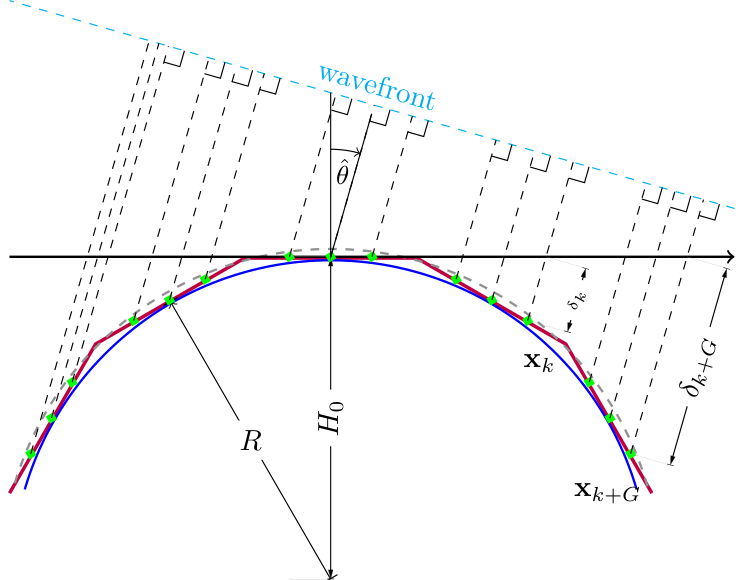

In [6]:
pic = prepare_pic()

define_right_angle_drawing(pic)


# background grid
# pic.draw((-1.4, -1.4), grid((1.4, 1.4), step="0.5cm"), help_lines=True, very_thin=True)

# circle
# pic.draw((0, 0), circle(radius=1))
# pic.draw((0, 0), node("$a$", radius=1))

nside = 12
hacky_adjustment = 0.1
R = diameter / 2 - hacky_adjustment
s = np.tan(2 * np.pi / nside / 2) * R * 2
d_inter_spacing = 0.5
if nside == 12:
    M = 5
    CORNERS = (nside - 1, nside, 1, 2, 3, 4)

    ms_to_draw_right_angle = (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
elif nside == 13:
    M = 6
    CORNERS = (nside - 2, nside - 1, nside, 1, 2, 3, 4)
    ms_to_draw_right_angle = (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

G = 3
theta_offset = np.arctan2(s, 2 * R) if M % 2 == 0 else 0
H0 = np.array([R, d_inter_spacing / 2 * (G - 1)]) @ np.array(
    [np.cos(theta_offset), np.sin(theta_offset)]
)
ms_to_use = range(1, M * G + 1)
diameter = 8


# polygon
scope = pic.scope()
scope.clip(
    (-diameter / 2, 0),
    "rectangle",
    (2, 0),
)
scope.node(
    "",
    opt=opts(
        "inner sep=0",
        "very thick",
        "regular polygon",
        #         "draw=purple",
        f"regular polygon sides={nside}",
        f"minimum size = {diameter}cm",
        #         "rotate=-70",
    ),
    name="P",
)

# # ploygon node
# for i in CORNERS:
#     pic.node("", opt=opts("square", "green"), at=f"(P.corner {i})")

pic.draw(
    "",
    "--".join(f"(P.corner {i})" for i in CORNERS),
    opt="thick,purple, very thick",
)

# inner circle
import numpy as np

_angle_per_side = (360 / (nside - 1)) * 1
_start_angle = CORNERS
_start_angle = _angle_per_side * 0.5
_end_angle = _angle_per_side * M
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*cos({_start_angle})"
    + r"},{"
    + rf"(veclen(\x1,\y1)-\pgflinewidth)*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(veclen(\x1,\y1)-\pgflinewidth)}})",
    opt=opts("blue", "thick"),
)
if M % 2 == 1:
    pic.coordinate("center-circ-surface", at="(P.side 1)")
    cases = dict(
        center_angle=8,
        delta_k=12,
        delta_k_1=15,
    )
else:
    pic.coordinate("center-circ-surface", at="(P.corner 1)")
    cases = dict(
        center_angle=11,
        delta_k=15,
        delta_k_1=18,
    )

# outer circle
# \path let \p1=($(b.center)-(b.side 1)$) in node[circle, inner sep=0, minimum width=, draw=gray, dashed] at (b) {};
_start_pt_str = (
    rf"sqrt(2)*veclen(\x1,\y1))/( sqrt(cos(360/{nside}) + 1 ) )-\pgflinewidth"
)
pic.draw(
    r"let \p1=($(P.center)-(P.side 1)$) in",
    r"($(P.center)+({"
    + rf"({_start_pt_str})*cos({_start_angle})"
    + r"},{"
    + rf"({_start_pt_str})*sin({_start_angle})"
    r"})$)",
    "arc",
    rf"({_start_angle}:{_end_angle}:{{(({_start_pt_str})}})",
    opt=opts(
        "blue",
        "thick",
        "draw=gray",
        "dashed",
    ),
)

# dimensions
pic.draw(
    "(P.center)",
    "--",
    "(P.side 2)",
    node("$R$", opt=opts("midway", "fill=white")),
    opt="|->|",
)


import dataclasses


@dataclasses.dataclass
class WaveFrontConf:
    vert_dist = 2
    margin = 1
    margin_left = 0
    theta = -16


wavefront = WaveFrontConf()

# pic.draw(
#     r"let \p1=($(P.side 1)$) in",
#     rf"(\x1, \y1 + {wavefront.vert_dist} cm)",
#     r"--",
#     rf"(P.side 1)",
#     opt=opts("purple", "dashed"),
# )

pic.coordinate("circ-right", at=rf"($(P.corner 11) + ({wavefront.margin}, 0) $)")
pic.coordinate("circ-left", at=rf"($(P.corner 4) - ({wavefront.margin_left}, 0)$)")


pic.path(
    r"let \p0=(center-circ-surface) in",
    r"let \p1=(circ-right) in",
    r"let \p2=(circ-left) in",
    coordinate(
        "wf-surface-left",
        at=rf"(\x1, {H0}cm)",
    ),
    coordinate(
        "wf-surface-right",
        at=rf"(\x2, {H0}cm)",
    ),
    coordinate(
        "wf-left",
        at=rf"(\x1, {{ \y0 + (\x1 - \x0) * tan({wavefront.theta}) + {wavefront.vert_dist}cm }} )",
    ),
    coordinate(
        "wf-right",
        at=rf"(\x2, {{ \y0 + (\x2 - \x0) * tan({wavefront.theta}) + {wavefront.vert_dist}cm }} )",
    ),
    coordinate(
        "wf-center",
        at=rf"(\x0, {{\y0 + {wavefront.vert_dist}cm }})",
    ),
)

pic.draw(
    rf"(wf-surface-left)",
    r"--",
    rf"(wf-surface-right)",
    opt=opts("<-", "black", "thick"),
)

pic.draw(
    rf"(wf-left)",
    r"--",
    node("wavefront", opt=opts("above", f"rotate={wavefront.theta}")),
    rf"(wf-right)",
    opt=opts("cyan", "dashed"),
)


for m in ms_to_use:
    origin = get_coor2(m, M=M, R=R, G=G, d_inter_spacing=d_inter_spacing)

    r = np.array(origin)

    _phase_delay = (R - r[1]) / np.cos(wavefront.theta * np.pi / 180)
    print(_phase_delay)
    pic.coordinate(
        "",
        opt=opts(
            "square",
#             "black",
            "green",
            "minimum size=1mm",
#             f"label={m}",
            "label distance=0mm",
        ),
        #     at=f"({s/2},4)",
        at=r,
    )
    #     pic.draw(
    #         origin,
    #         "--",
    #         from_some_distance_away(
    #             tuple(origin),
    #             tuple((origin[0], 10)),
    #             distance=f"{_phase_delay}cm",
    #             angle=wavefront.theta,
    #         ),
    #         opt=opts("black", "dashed"),
    #     )
    # ($(#1)!(#3)!(#2)$)

    if m in ms_to_draw_right_angle:
        draw_right_angle(pic, "(wf-left)", "(wf-right)", tuple(origin))

    pic.draw(
        origin,
        "--",
        pt_of_intersect(
            "(wf-left)",
            origin,
            "(wf-right)",
        ),
        #         f"($(wf-left)!{tuple(origin)}!(wf-right)$)",
        opt=opts("black", "dashed"),
    )

    if m == cases["center_angle"]:
        pic.path(
            r"let \p0=(P.center) in",
            coordinate(
                "O",
                at=rf"(\x0, {{\y0 + {H0}cm}})",
            ),
        )

        _pt = from_some_distance_away(
            "(O)", "(wf-center)", angle=wavefront.theta, distance="1.8cm"
        )
        #         pic.coordinate("O", "(wf-center)")
        pic.coordinate("p2", "(wf-center)")
        pic.coordinate("p1", _pt)

        pic.draw(
            r'pic [draw,<-,angle radius=1.3cm,angle eccentricity=0.8,"\small $\hat{\theta}$"] '
            rf"{{angle = p1--O--p2}}"
        )

        pic.draw(
            _pt,
            "--",
            "(O)",
            "--",
            "(wf-center)",
        )
    if m == cases["delta_k"]:
        pic.raw(
            dimline(
                r"\tiny $\delta_k$",
                tuple(origin),
                from_some_distance_away(
                    tuple(origin),
                    tuple((origin[0], 10)),
                    distance=f"{_phase_delay}cm",
                    angle=wavefront.theta,
                ),
                flip=True,
                extension_length="-5mm",
            )
        )

    if m == cases["delta_k_1"]:
        pic.raw(
            dimline(
                r" $\delta_{k+G}$",
                tuple(origin),
                from_some_distance_away(
                    tuple(origin),
                    tuple((origin[0], 10)),
                    distance=f"{_phase_delay}cm",
                    angle=wavefront.theta,
                ),
                flip=True,
                extension_length="-5mm",
            )
        )

    #     print(intnp.ceil(M * G / 2))
    if m == int((M * G / 2)):
        pic.raw(
            dimline(
                r"$H_0$",
                pt_of_intersect((-10, 0), tuple(origin), (10, 0)),
                tuple(origin),
                flip=True,
                extension_length="-5mm",
            )
        )

pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=left:$\mathbf{x}_{k+G}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 11)",
)
pic.coordinate(
    "",
    opt=opts(
        "minimum size=1.5mm",
        r"label=below left:$\mathbf{x}_{k}$",
        "label distance=4mm",
    ),
    at=f"(P.corner 12)",
)


# print(pic.code())
# pic.demo(dpi=210)
# print(pic.document_code())
pic.show(dpi=210)

1 4.0 4.0 0.5523132672655497
2 4.0 4.0 1.0352761804100838
3 4.0 4.0 1.518239093554618
4 4.0 4.0 2.474873734152917
5 4.0 4.0 2.8284271247461903
6 4.0 4.0 3.181980515339464
7 4.0 4.0 3.734293782605013
8 4.0 4.0 3.8637033051562732
9 4.0 4.0 3.9931128277075336
10 4.0 4.0 3.9931128277075336
11 4.0 4.0 3.8637033051562732
12 4.0 4.0 3.734293782605013
13 4.0 4.0 3.181980515339464
14 4.0 4.0 2.8284271247461903
15 4.0 4.0 2.474873734152917
0.006887707519129464
4.208848353332226
(15, 50)


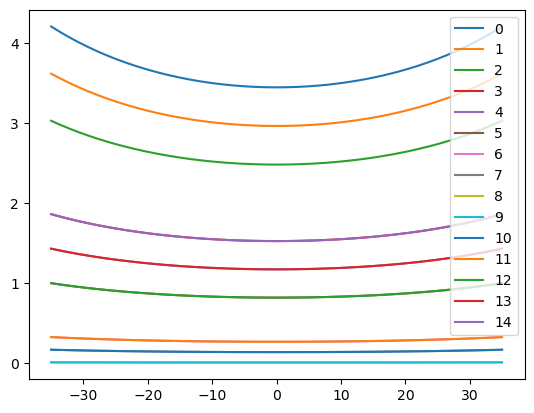

In [7]:
_R = diameter / 2  # - hacky_adjustment

s = np.tan(2 * np.pi / nside / 2) * _R * 2
thetaw = 2 * np.arctan2(s, 2 * _R)
data = []

t = np.linspace(-35, 35)
t = t * np.pi / 180

for m in range(1, 16):
    M = 6

    hacky_adjustment = 0.1
    _R = diameter / 2  # - hacky_adjustment
    origin = get_coor2(m, M=M, R=_R, G=3)

    r = np.array(origin)

    if M % 2 == 0:
        # is even
        __R = _R  # + s/2*np.sin(thetaw/2)
    #         __R = _R + .003425101847987

    #         __R = _R +
    else:
        __R = _R

    print(m, diameter / 2, __R, r[1])

    data.append((__R - r[1]) / np.cos(t))

data = np.array(data)  # [9:11, :]
print(data.min())
print(data.max())
print(data.shape)
plt.plot(t * 180 / np.pi, data.T, label=list(range(data.shape[0])))
plt.legend()


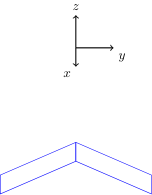

In [8]:
pic = Picture(opt="tdplot_main_coords")
pic.usepackage("tikz-3dplot")
pic.usetikzlibrary("calc,shapes.geometric")

pic.add_document_code(r"\tdplotsetmaincoords{70}{110}")
pic.add_document_code(r"\tdplotsetmaincoords{60}{90}")

# circle
pic.usetikzlibrary("angles,quotes")

pic.add_preamble(
    r"""
\def\centerarc[#1](#2)(#3:#4:#5)% Syntax: [draw options] (center) (initial angle:final angle:radius)
    { \draw[#1] ($(#2)+({#5*cos(#3)},{#5*sin(#3)})$) arc (#3:#4:#5); }
"""
)


# pic = Picture(scale=3, line_cap="round")
pic.usepackage(r"tikz-dimline")

pic.tikzset(
    r"""dot/.style={circle,fill=blue,minimum size=3pt, inner sep=0pt},
         square/.style={rectangle,fill=red,minimum size=4pt, inner sep=0pt,%    
                    rotate=30,anchor=center},%
        mytext/.style={anchor=north,text width=3cm,align=center}"""
)


nside = 12
CORNERS = (11, 12, 1, 2, 3, 4)
diameter = 8

# polygon
# pic.node(
#     "",
#     opt=opts(
#         "inner sep=0",
#         "very thick",
#         "regular polygon",
#         #         "draw=purple",
#         f"regular polygon sides={nside}",
#         f"minimum size = {diameter}cm",
#         #         "rotate=-70",
#     ),
#     name="P",
# )


def plane_vertices_to_path(*vertices):
    assert len(vertices) >= 3
    # connect the last vertex to the first one
    vertices = [*vertices, vertices[0]]
    return "--".join(map(lambda x: f"({','.join(map(str,x))})", vertices))


# vertices
points = np.array(
    [
        [0, 0, 0],
        [4, 0, 0],
        [4, 4, 0],
        [0, 4, 0],
        [0, 0, 4],
        [4, 0, 4],
        [4, 4, 4],
        [0, 4, 4],
    ]
)

principle_axis = np.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
principle_axis[:, 0] -= 5

for i, data in zip(
    range(3),
    [
        ("anchor=north east", "$x$"),
        ("anchor=north west", "$y$"),
        ("anchor=south", "$z$"),
    ],
):
    pic.draw(
        principle_axis[0],
        "--",
        principle_axis[i + 1],
        node(data[1], opt=data[0]),
        opt="thick,->",
    )


pic.draw(
    plane_vertices_to_path([0, 0, 0], [1, 0, 0], [1, -2, -1], [0, -2, -1]),
    opt="blue",
)
pic.draw(
    plane_vertices_to_path([0, 0, 0], [1, 0, 0], [1, 2, -1], [0, 2, -1]),
    opt="blue",
)


# print(pic.document_code())
pic.demo()